In [4]:
# CNN Baseline model script for calcium signal prediction

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tifffile import imread
from skimage.transform import resize
from scipy.ndimage import median_filter
from skimage.filters import gaussian
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------------
# CONFIG
# ----------------------------
CONFIG = {
    "resize_shape": (64, 64),
    "save_vis_dir": os.path.join(os.path.expanduser("~"), "Desktop", "CNN_Predictions")
}
os.makedirs(CONFIG["save_vis_dir"], exist_ok=True)



In [5]:

# ----------------------------
# Preprocessing
# ----------------------------
def denoise_gaussian_median(frame, median_size=3, gaussian_sigma=1.0):
    return gaussian(median_filter(frame, size=median_size), sigma=gaussian_sigma)

# ----------------------------
# Sequence Loader
# ----------------------------
def load_tif_node_sequences(path, window=5, frame_skip=1, denoise_sigma=1.0):
    stack = imread(path)
    stack_denoised = np.array([denoise_gaussian_median(f, gaussian_sigma=denoise_sigma) for f in stack])
    stack_resized = np.array([resize(f, CONFIG["resize_shape"]) for f in stack_denoised])
    norm_stack = (stack_resized - stack_resized.min()) / (stack_resized.max() - stack_resized.min())
    norm_stack = norm_stack * 2 - 1
    flattened_stack = norm_stack.reshape(len(norm_stack), -1)
    sequences = []
    for i in range(0, len(flattened_stack) - window, frame_skip):
        seq = flattened_stack[i:i+window]
        target = flattened_stack[i+window]
        sequences.append((seq, target))
    return sequences

# ----------------------------
# Dataset
# ----------------------------
class FrameSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, target = self.sequences[idx]

        T = seq.shape[0]  # time window
        H, W = CONFIG["resize_shape"]

        # Reshape from flat (T, H*W) → (T, H, W)
        seq = seq.reshape(T, H, W)

        # Convert to torch tensor first
        seq = torch.tensor(seq, dtype=torch.float32)

        # Add channel dim → (T, 1, H, W)
        seq = seq.unsqueeze(1)

        # Reorder to (1, T, H, W) for Conv3D
        seq = seq.permute(1, 0, 2, 3)

        # Target frame: reshape and flatten
        target = torch.tensor(target, dtype=torch.float32).reshape(64, 64).flatten()

        return seq, target





In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SparseBottleneck(nn.Module):
    def __init__(self, in_channels, sparsity_lambda=1e-4):
        super().__init__()
        self.linear = nn.Linear(in_channels, in_channels)
        self.sparsity_lambda = sparsity_lambda

    def forward(self, x):
        x = self.linear(x)
        # L1 penalty will be added externally in loss
        return x

class CalciumCNN3D(nn.Module):
    def __init__(self, in_channels=1, sparsity_lambda=1e-4):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 8, 8))  # was (1, 8, 8)
        )

        self.sparse = SparseBottleneck(4096, sparsity_lambda)
        self.fc = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 64 * 64)  # Output frame
        )

    def forward(self, x):
        x = self.conv_block(x)  # (B, C, 1, 8, 8)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.sparse(x)
        print("Shape before sparse layer:", x.shape)

        return self.fc(x)


In [7]:


def train_model(model, loader, optimizer, loss_fn_main, loss_fn_alt, device):
    model.train()
    total_main = 0
    total_alt = 0
    total_sparse = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out = model(x)
        
        loss_main = loss_fn_main(out, y)
        loss_alt = loss_fn_alt(out, y)

        # Sparsity loss (L1 penalty on sparse bottleneck weights)
        sparse_loss = model.sparse.sparsity_lambda * model.sparse.linear.weight.abs().sum()
        
        total_loss = loss_main + sparse_loss

        total_loss.backward()
        optimizer.step()

        total_main += loss_main.item()
        total_alt += loss_alt.item()
        total_sparse += sparse_loss.item()

    return (
        total_main / max(1, len(loader)),
        total_alt / max(1, len(loader)),
        total_sparse / max(1, len(loader))
    )


def evaluate_model(model, loader, loss_fn_main, loss_fn_alt, device, return_preds=False):
    model.eval()
    total_main = 0
    total_alt = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss_main = loss_fn_main(out, y)
            loss_alt = loss_fn_alt(out, y)
            total_main += loss_main.item()
            total_alt += loss_alt.item()
            if return_preds:
                all_preds.append(out.cpu().numpy())
                all_targets.append(y.cpu().numpy())
    if return_preds:
        return total_main / len(loader), total_alt / len(loader), all_preds, all_targets
    return total_main / len(loader), total_alt / len(loader)


In [8]:

# ----------------------------
# Visualization Function (Saved)
# ----------------------------
def visualize_predictions(preds, targets, shape=(128, 128), num_examples=5):
    for i in range(min(num_examples, len(preds))):
        pred_img = preds[i].reshape(-1, *shape)
        target_img = targets[i].reshape(-1, *shape)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(pred_img[0], cmap='viridis')
        axes[0].set_title("Predicted")
        axes[1].imshow(target_img[0], cmap='viridis')
        axes[1].set_title("Ground Truth")
        axes[2].imshow(np.abs(pred_img[0] - target_img[0]), cmap='hot')
        axes[2].set_title("Difference")
        for ax in axes:
            ax.axis('off')

        plt.tight_layout()
        save_path = os.path.join(CONFIG["save_vis_dir"], f"cnn_example_{i}.png")
        plt.savefig(save_path)
        plt.close()

✅ No overlap detected between train/val/test splits.
Train batch shape: torch.Size([8, 1, 5, 64, 64])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before spa

C:\Users\Platypus\AppData\Local\Temp\ipykernel_10728\2500302787.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn.pt"))


Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse layer: torch.Size([8, 4096])
Shape before sparse 

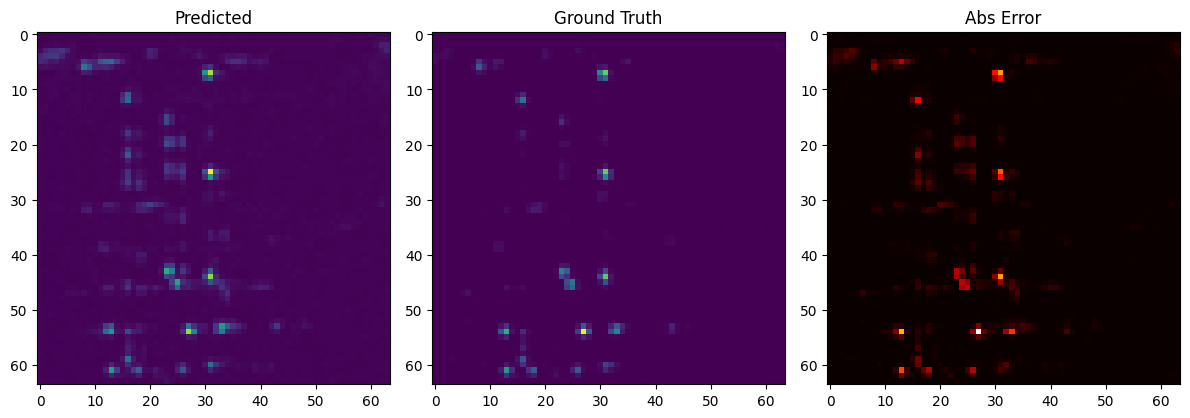

Shape before sparse layer: torch.Size([1, 4096])


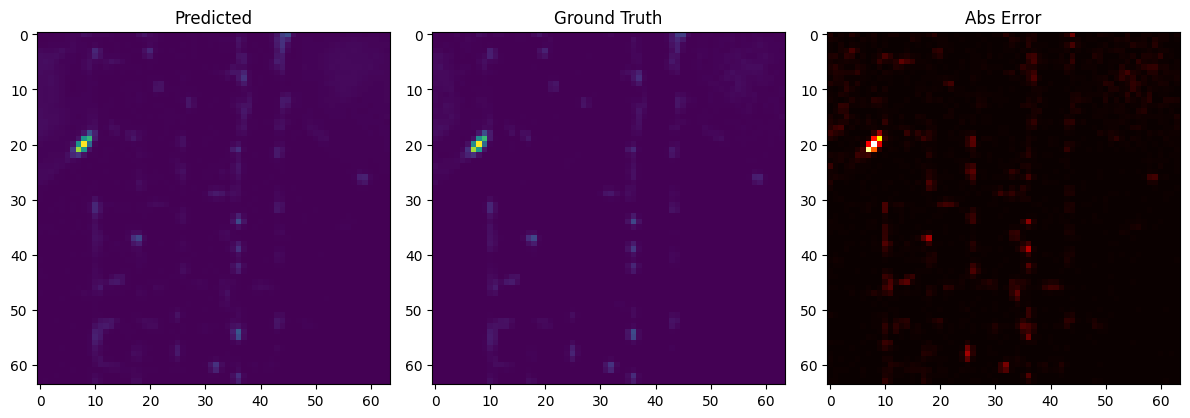

Shape before sparse layer: torch.Size([1, 4096])


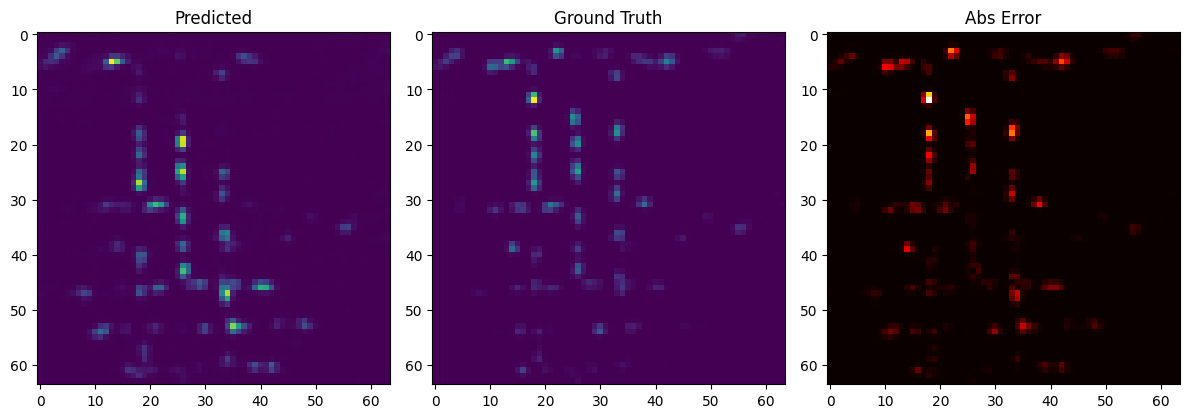

In [10]:
# ----------------------------
# Main Training Block
# ----------------------------
if __name__ == "__main__":
    file_paths = [
        "C:/Users/Platypus/Documents/CellNet/Real_Time_CS_Experiment-1093.tif",
        "C:/Users/Platypus/Documents/CellNet/Flow prior to chemical stimulation_Figure6C.tif",
        "C:/Users/Platypus/Documents/CellNet/Figure8.tif",
        "C:/Users/Platypus/Documents/CellNet/5uM_per_litre_Figure6_ChemicalStimulation.tif",
        "C:/Users/Platypus/Documents/CellNet/Cell Knocked_Figure7.tif"
    ]

    all_sequences = []
    for path in file_paths:
        seqs = load_tif_node_sequences(path, window=5)
        all_sequences.extend(seqs)

    train_val, test_seq = train_test_split(all_sequences, test_size=0.15, random_state=42)
    train_seq, val_seq = train_test_split(train_val, test_size=0.176, random_state=42)

        # Check for overlap between train/val/test
    train_set = set(map(lambda x: x[0].tobytes(), train_seq))
    val_set = set(map(lambda x: x[0].tobytes(), val_seq))
    test_set = set(map(lambda x: x[0].tobytes(), test_seq))

    assert train_set.isdisjoint(val_set), "Overlap between train and val!"
    assert train_set.isdisjoint(test_set), "Overlap between train and test!"
    assert val_set.isdisjoint(test_set), "Overlap between val and test!"
    print("✅ No overlap detected between train/val/test splits.")



    
    train_ds = FrameSequenceDataset(train_seq)
    val_ds = FrameSequenceDataset(val_seq)
    test_ds = FrameSequenceDataset(test_seq)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8)
    test_loader = DataLoader(test_ds, batch_size=8)


    input_size = CONFIG["resize_shape"][0] * CONFIG["resize_shape"][1]
    model = CalciumCNN3D(in_channels=1, sparsity_lambda=1e-6).to("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn_main = nn.L1Loss()
    loss_fn_alt = nn.SmoothL1Loss()  # Huber loss


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0


    train_losses = []
    train_alt_losses = []
    val_losses = []
    val_alt_losses = []

    x, y = next(iter(train_loader))
    print(f"Train batch shape: {x.shape}")  # Should be (batch_size, 1, T, H, W)


    for epoch in range(100):
        train_main, train_alt, train_sparse = train_model(
            model, train_loader, optimizer, loss_fn_main, loss_fn_alt, device
        )
        
        val_main, val_alt = evaluate_model(
            model, val_loader, loss_fn_main, loss_fn_alt, device
        )
         
        
        torch.cuda.empty_cache()


        train_losses.append(train_main)
        train_alt_losses.append(train_alt)
        val_losses.append(val_main)
        val_alt_losses.append(val_alt)

        print(f"Epoch {epoch+1} | Train Main: {train_main:.4f} | Alt: {train_alt:.4f} | Sparse: {train_sparse:.6f} || Val Main: {val_main:.4f} | Alt: {val_alt:.4f}")

        if val_main < best_val_loss:
            best_val_loss = val_main
            patience_counter = 0
            torch.save(model.state_dict(), "best_cnn.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break



    model.load_state_dict(torch.load("best_cnn.pt"))
   
    test_main_loss, test_alt_loss, preds, targets = evaluate_model(model, test_loader, loss_fn_main, loss_fn_alt, device, return_preds=True)

    pred_flat = np.concatenate(preds).flatten()
    target_flat = np.concatenate(targets).flatten()

    corr, _ = pearsonr(pred_flat, target_flat)
    mae = mean_absolute_error(target_flat, pred_flat)

    print("\n✅ Final CNN Test Metrics:")
    print(f"  - Test Loss (L1):       {test_main_loss:.4f}")
    print(f"  - Test Loss (Huber):    {test_alt_loss:.4f}")
    print(f"  - MAE:                  {mae:.4f}")
    print(f"  - Pearson Correlation:  {corr:.4f}")

    visualize_predictions(preds, targets, shape=CONFIG["resize_shape"])




     # ----------------------------
    # Metric Plots
    # ----------------------------
    val_maes = []
    val_corrs = []

    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        with torch.no_grad():
            preds_batch = model(x_batch).cpu().numpy()
            y_batch = y_batch.cpu().numpy()
            val_maes.append(mean_absolute_error(y_batch.flatten(), preds_batch.flatten()))
            val_corrs.append(np.corrcoef(y_batch.flatten(), preds_batch.flatten())[0, 1])

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("L1 Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_maes, color='orange')
    plt.title("Validation MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")

    plt.subplot(1, 3, 3)
    plt.plot(val_corrs, color='green')
    plt.title("Validation Pearson Corr")
    plt.xlabel("Epoch")
    plt.ylabel("Correlation")

    plt.tight_layout()
    metric_path = os.path.join(CONFIG["save_vis_dir"], "cnn_training_metrics.png")
    plt.savefig(metric_path)
    plt.close()

    # Print final metrics for interpretation
    print("Final Metrics:")
    print(f"  - Final Val Loss: {val_losses[-1]:.4f}")
    print(f"  - Final Val MAE: {val_maes[-1]:.4f}")
    print(f"  - Final Val Pearson Correlation: {val_corrs[-1]:.4f}")


    # Final manual prediction inspection
model.eval()
with torch.no_grad():
    for i in range(3):
        x, y = test_ds[i]
        x = x.unsqueeze(0).to(device)
        pred = model(x).cpu().numpy().reshape(CONFIG["resize_shape"])
        true = y.numpy().reshape(CONFIG["resize_shape"])

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(pred, cmap='viridis')
        plt.title("Predicted")
        plt.subplot(1, 3, 2)
        plt.imshow(true, cmap='viridis')
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(np.abs(pred - true), cmap='hot')
        plt.title("Abs Error")
        plt.tight_layout()
        plt.show()





## 🧪 **Problem: CNN always predicts nearly the same calcium frame**

### Goal:

Train a **pure CNN** to predict future calcium frames from past ones, with activations representing **blobs**, not pixels. The model should capture **spatiotemporal variation** using a **3D CNN + sparse bottleneck**, and predict realistic calcium signal propagation patterns.

---

## ✅ **1. Initial Model Setup**

### ✅ Model: `CalciumCNN3D` with a sparse bottleneck

```python
class SparseBottleneck(nn.Module):
    def __init__(self, in_channels, sparsity_lambda=1e-4):
        super().__init__()
        self.linear = nn.Linear(in_channels, in_channels)
        self.sparsity_lambda = sparsity_lambda

    def forward(self, x):
        return self.linear(x)
```

```python
self.conv_block = nn.Sequential(
    nn.Conv3d(...),
    nn.BatchNorm3d(...),
    nn.ReLU(),
    ...
    nn.AdaptiveAvgPool3d((1, 8, 8))  # ⚠️
)

self.sparse = SparseBottleneck(64 * 8 * 8, sparsity_lambda)
self.fc = nn.Sequential(
    nn.Linear(64 * 8 * 8, 512),
    nn.ReLU(),
    nn.Linear(512, 128*128)
)
```

### ✅ Dataset: Sequence of flattened calcium frames reshaped to `(1, T, H, W)` per sample

### Outcome:

* Code ran
* Model trained with good convergence (L1 loss dropped from 0.6 → 0.03)
* BUT: Predictions looked **visually identical across all test samples**

---

## 🚫 **2. Reduced Sparsity Penalty**

### Why:

To test if strong regularization was collapsing the output.

### What you changed:

```python
sparsity_lambda = 1e-6
```

### Outcome:

* Sparse loss decreased
* Training improved slightly
* **Still predicted almost the same image every time**

---

## 🚫 **3. Debugging via Visualization**

### What you added:

```python
model.eval()
with torch.no_grad():
    for i in range(3):
        x, y = test_ds[i]
        x = x.unsqueeze(0).to(device)
        pred = model(x).cpu().numpy().reshape(128, 128)
        true = y.numpy().reshape(128, 128)
        
        plt.imshow(pred)
```

### Outcome:

* Verified: **outputs were nearly identical**
* Confirmed issue wasn’t metrics—it was output variance collapse

---

## 🚫 **4. Kept Global Pooling Layer**

```python
nn.AdaptiveAvgPool3d((1, 8, 8))
```

### Why this was a problem:

* Collapsed the entire **temporal dimension**
* Reduced spatial maps to **tiny 8×8 feature blobs**
* Crushed variation needed to reconstruct a 128×128 frame

### Outcome:

* **Bottleneck was too severe**
* Network chose “safe” average-looking frame prediction

---

## 🚫 **5. No spatial reconstruction (flatten → FC output)**

```python
x = x.view(x.size(0), -1)
x = self.sparse(x)
x = self.fc(x)  # Linear output
```

### Why this was a problem:

* No upsampling or spatial reasoning
* Model learned one abstract latent vector and mapped it to pixels
* **No pixel-wise correspondence with temporal context**

---

## ✅ What Still Needs To Be Done (Next Steps)

### ✅ 1. **Remove Adaptive Pooling**

Replace:

```python
nn.AdaptiveAvgPool3d((1, 8, 8))
```

with:

```python
nn.Identity()
```

Or remove that layer altogether.

---

### ✅ 2. **Replace `fc` with `ConvTranspose2d` decoder**

Rather than:

```python
x = self.sparse(x.view(batch_size, -1))
out = self.fc(x)  # (B, 128*128)
```

Use:

```python
x = x.view(batch_size, C, T, H, W)
x = self.sparse(x.view(batch_size, -1))
x = x.view(batch_size, 64, 2, 16, 16)  # or whatever shape works

x = self.decoder(x)  # ConvTranspose3d to reconstruct temporal/spatial output
```

---

## 🧠 Summary Table

| Change Attempted                   | Purpose                                  | Result                        |
| ---------------------------------- | ---------------------------------------- | ----------------------------- |
| Add sparse bottleneck              | Encourage interpretable low-dim features | ✅ works, but collapsed output |
| Reduce sparsity lambda             | Prevent over-regularization              | ❌ no improvement              |
| Add visualization                  | Manually inspect output vs truth         | ✅ confirmed flat output       |
| Retain AdaptiveAvgPool3d           | Compress spatiotemporal info             | ❌ too aggressive              |
| Output via `Linear(512 → 128×128)` | Generate image from flat latent          | ❌ lacked spatial decoding     |

